Total Sentences: 9
Sample Sentence: the speed of transmission is an important point of difference between the two viruses
Training samples: 159 | Vocabulary size: 101
Epoch 1/80
5/5 [==============================] - 0s 3ms/step - loss: 4.6142 - accuracy: 0.0314
Epoch 2/80
5/5 [==============================] - 0s 4ms/step - loss: 4.6015 - accuracy: 0.0503
Epoch 3/80
5/5 [==============================] - 0s 4ms/step - loss: 4.5836 - accuracy: 0.0503
Epoch 4/80
5/5 [==============================] - 0s 3ms/step - loss: 4.5475 - accuracy: 0.0503
Epoch 5/80
5/5 [==============================] - 0s 4ms/step - loss: 4.4899 - accuracy: 0.0503
Epoch 6/80
5/5 [==============================] - 0s 4ms/step - loss: 4.3957 - accuracy: 0.0503
Epoch 7/80
5/5 [==============================] - 0s 3ms/step - loss: 4.2957 - accuracy: 0.0503
Epoch 8/80
5/5 [==============================] - 0s 4ms/step - loss: 4.2322 - accuracy: 0.0503
Epoch 9/80
5/5 [==============================] - 0s 4ms/step - l

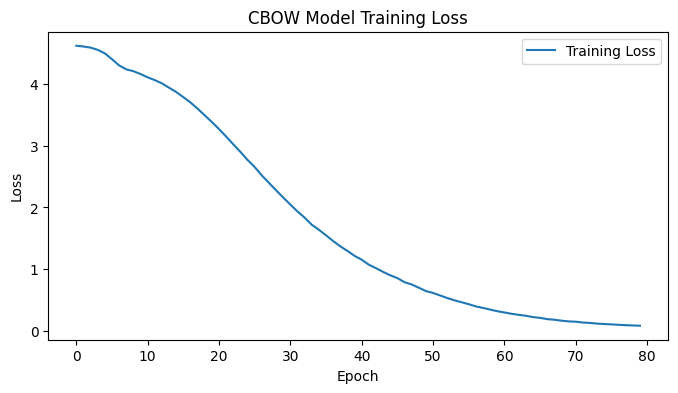


Vocabulary Sample: ['the', 'speed', 'of', 'transmission', 'is', 'an', 'important', 'point', 'difference', 'between', 'two', 'viruses', 'influenza', 'has', 'a']

Context: ['known', 'as', 'structured', 'learning']  -->  Predicted center word: making

Context: ['transformers', 'have', 'applied', 'to']  -->  Predicted center word: between

Context: ['where', 'they', 'produced', 'results']  -->  Predicted center word: infections

Context: ['cases', 'surpassing', 'expert', 'performance']  -->  Predicted center word: to

 CBOW Model training completed and saved successfully.


In [2]:
# ============================================================
# LP-IV Assignment: Implement Continuous Bag of Words (CBOW)
# Stages:
# a. Data preparation
# b. Generate training data
# c. Train model
# d. Output
# ============================================================

import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# ------------------------------------------------------------
# a. Data Preparation
# ------------------------------------------------------------

# Read your text file (Document 1)
data = """The speed of transmission is an important point of difference between the two viruses. Influenza has a shorter median incubation period (the time from infection to appearance of symptoms) and a shorter serial interval (the time between successive cases) than COVID-19 virus. The serial interval for COVID-19 virus is estimated to be 5-6 days, while for influenza virus, the serial interval is 3 days. This means that influenza can spread faster than COVID-19. 

Further, transmission in the first 3-5 days of illness, or potentially pre-symptomatic transmission –transmission of the virus before the appearance of symptoms – is a major driver of transmission for influenza. In contrast, while we are learning that there are people who can shed COVID-19 virus 24-48 hours prior to symptom onset, at present, this does not appear to be a major driver of transmission. 

The reproductive number – the number of secondary infections generated from one infected individual – is understood to be between 2 and 2.5 for COVID-19 virus, higher than for influenza. However, estimates for both COVID-19 and influenza viruses are very context and time-specific, making direct comparisons more difficult."""
# Clean text: remove punctuation/numbers and lowercase
sentences = data.split('.')
clean_sent = []
for sentence in sentences:
    if sentence.strip() == "":
        continue
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    sentence = re.sub(r'(?:^| )\w (?:$| )', ' ', sentence).strip()
    sentence = sentence.lower()
    clean_sent.append(sentence)

print("Total Sentences:", len(clean_sent))
print("Sample Sentence:", clean_sent[0])

# ------------------------------------------------------------
# b. Generate Training Data
# ------------------------------------------------------------

tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_sent)
sequences = tokenizer.texts_to_sequences(clean_sent)

index_to_word = {}
word_to_index = {}

for i, sequence in enumerate(sequences):
    words = clean_sent[i].split()
    for j, value in enumerate(sequence):
        index_to_word[value] = words[j]
        word_to_index[words[j]] = value

vocab_size = len(tokenizer.word_index) + 1
emb_size = 10        # --- Alternative: emb_size = 50 ---
context_size = 2

contexts, targets = [], []

for sequence in sequences:
    for i in range(context_size, len(sequence) - context_size):
        target = sequence[i]
        context = [
            sequence[i - 2], sequence[i - 1],
            sequence[i + 1], sequence[i + 2]
        ]
        contexts.append(context)
        targets.append(target)

X = np.array(contexts)
Y = np.array(targets)

print(f"Training samples: {X.shape[0]} | Vocabulary size: {vocab_size}")

# ------------------------------------------------------------
# c. Train CBOW Model
# ------------------------------------------------------------

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=emb_size, input_length=2 * context_size),
    Lambda(lambda x: tf.reduce_mean(x, axis=1)),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X, Y, epochs=80, verbose=1)
# --- Alternative: model.fit(X, Y, epochs=50, batch_size=64) ---

# ------------------------------------------------------------
# d. Output & Evaluation
# ------------------------------------------------------------

# Plot loss & accuracy
plt.figure(figsize=(8,4))
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label='Training Loss')
plt.title("CBOW Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Obtain word embeddings
embeddings = model.get_weights()[0]
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

print("\nVocabulary Sample:", list(index_to_word.values())[:15])

# Test predictions
test_sentences = [
    "known as structured learning",
    "transformers have applied to",
    "where they produced results",
    "cases surpassing expert performance"
]

for sent in test_sentences:
    test_words = sent.split(" ")
    x_test = [word_to_index.get(i, 0) for i in test_words]
    x_test = np.array([x_test])
    pred = model.predict(x_test, verbose=0)
    pred_word = index_to_word.get(np.argmax(pred[0]), "unknown")
    print(f"\nContext: {test_words}  -->  Predicted center word: {pred_word}")

# Save the trained model
model.save("cbow_model_doc1.keras")

print("\n CBOW Model training completed and saved successfully.")
